# 基于Alex网络的书法字体分类
### 智能2002 202005100207 王明强
## 1.实验内容
1. 搭建卷积神经网络
2. 利用书法字体数据集训练搭建好的神经网络模型，并给出每次训练的结果

## 2.实验过程
#### 2.1 引入必要库

In [1]:
import tensorflow as tf
import keras
from keras.layers import Activation,Conv2D, BatchNormalization, Dense
from keras.layers import Dropout, Flatten, Input, MaxPooling2D, ZeroPadding2D
from keras import Model

#### 2.2 建立Alex模型

In [2]:
IMSIZE = 227
input_layer = Input([IMSIZE,IMSIZE,3]) # 输入规则227x227x3,3代表每张图有三个通道（彩色图片）
x = input_layer # 将input_layer的值传递给变量x
# 96个11x11的卷积核，选择relu为激活函数，消耗参数：(11x11x3+1)x96=34944
x = Conv2D(96,[11,11],strides = [4,4], activation = 'relu')(x)
# 池化操作，池化核为3x3，步长为2，，输出形状为(27, 27, 96),不消耗参数
x = MaxPooling2D([3,3], strides = [2,2])(x)
# 256个5x5的卷积核，选择relu为激活函数，消耗参数：(5x5x96+1)x256=614656
x = Conv2D(256,[5,5],padding = "same", activation = 'relu')(x)
# 池化操作，池化核为3x3，步长为2，，输出形状为(13, 13, 256),不消耗参数
x = MaxPooling2D([3,3], strides = [2,2])(x)
# 384个3x3的卷积核，选择relu为激活函数，输出形状（13,13,384）消耗参数：(3x3x256+1)x384=885120
x = Conv2D(384,[3,3],padding = "same", activation = 'relu')(x)
# 384个3x3的卷积核，选择relu为激活函数，输出形状（13,13,384）消耗参数：(3x3x384+1)x384=1327488
x = Conv2D(384,[3,3],padding = "same", activation = 'relu')(x)
# 256个3x3的卷积核，选择relu为激活函数，输出形状（13,13,256）消耗参数：(3x3x384+1)x256=884992
x = Conv2D(256,[3,3],padding = "same", activation = 'relu')(x)
# 池化操作，池化核为3x3，步长为2，，输出形状为(6, 6, 256)，不消耗参数
x = MaxPooling2D([3,3], strides = [2,2])(x)
x = Flatten()(x) # 拉平，向量长度为6x6x256=9216，不消耗参数
# 全连接层4096个神经元，选择relu激活函数，消耗参数：（9216+1）x4096=37752832
x = Dense(4096,activation = 'relu')(x)
# 随机失活（失活率为0.5），不消耗参数，但神经元个数还是为4096个
x = Dropout(0.5)(x)
# 全连接层4096个神经元，选择relu激活函数，消耗参数：（4096+1）x4096=16781312
x = Dense(4096,activation = 'relu')(x)
# 随机失活（失活率为0.5），不消耗参数，但神经元个数还是为4096个
x = Dropout(0.5)(x)
# 全连接层2个神经元，选择softmax激活函数，消耗参数（4096+1）x2=8194
x = Dense(2,activation = 'softmax')(x)
output_layer=x # 将现在的x变量赋给output_layer变量
model=Model(input_layer,output_layer) # 创建Model对象，传递input_layer和output_layer
# 统计参数个数，参数个数总数为：（34944+614656+885120+1327488+884992+37752832+16781312+8194）= 58289538
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       885120

#### 2.3 读取书法字体数据，将书法字体分为隶书和行书两种类别，并显示部分数据

Found 5526 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


<Figure size 640x480 with 0 Axes>

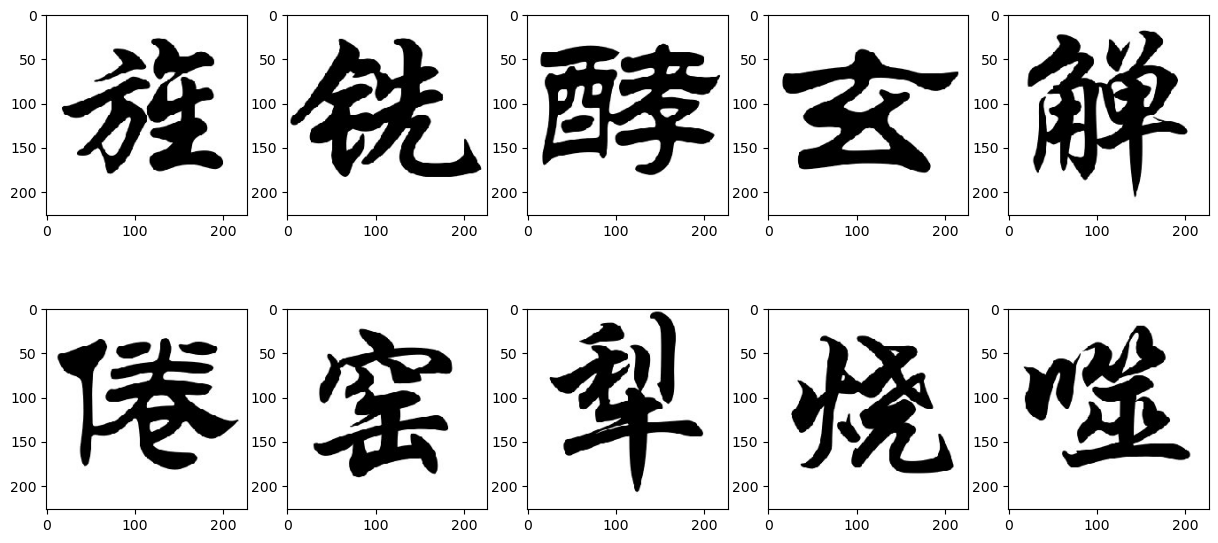

In [3]:
# 数据生成器
from keras.preprocessing.image import ImageDataGenerator
IMSIZE=227 # 图片规格
# 加载验证集图片数据，并将每张图片强制设置为227x227（因为AlexNet规定输入大小就是227x227）
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
 './data/ChineseStyle/test/',
 target_size=(IMSIZE, IMSIZE),
 batch_size=200,
 class_mode='categorical')
# 加载训练集图片数据，并将每张图片强制设置为227x227（因为AlexNet规定输入大小就是227x227）
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
 './data/ChineseStyle/train',
 target_size=(IMSIZE, IMSIZE),
 batch_size=200,
 class_mode='categorical')

# 数据展示
from matplotlib import pyplot as plt
plt.figure() # 创建画板
fig,ax = plt.subplots(2,5) # 绘制2x5的子图
fig.set_figheight(7) # 设置画板高度为7
fig.set_figwidth(15) # 设置画板宽度为15
ax=ax.flatten() # 将子图的坐标位置转换成长度为10的一维数据
X,Y=next(validation_generator) # 获取10张验证集图片数据
for i in range(10): ax[i].imshow(X[i,:,:,:]) # 分别在每个坐标位置显示图片

#### 2.4 训练模型，并绘制acc与loss的折线图

In [4]:
# AlexNet编译运行
from keras.optimizers import Adam
 # 损失函数选择分类交叉熵损失函数，优化器选择adam（学习率为0.001），使用准确率作为判断尺度
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
# 使用训练集训练模型，验证集评估模型，一共经过10轮训练
history=model.fit(train_generator,epochs=10,validation_data=validation_generator)

Epoch 1/10
40/40 [==============================] - 202s 5s/step - loss: 0.9023 - accuracy: 0.6509 - val_loss: 0.2230 - val_accuracy: 0.9235
Epoch 2/10
40/40 [==============================] - 200s 5s/step - loss: 0.1348 - accuracy: 0.9576 - val_loss: 0.0546 - val_accuracy: 0.9861
Epoch 3/10
40/40 [==============================] - 200s 5s/step - loss: 0.0346 - accuracy: 0.9921 - val_loss: 0.0167 - val_accuracy: 0.9957
Epoch 4/10
40/40 [==============================] - 200s 5s/step - loss: 0.0167 - accuracy: 0.9959 - val_loss: 0.0139 - val_accuracy: 0.9958
Epoch 5/10
40/40 [==============================] - 203s 5s/step - loss: 0.0102 - accuracy: 0.9965 - val_loss: 0.0166 - val_accuracy: 0.9946
Epoch 6/10
40/40 [==============================] - 206s 5s/step - loss: 0.0098 - accuracy: 0.9969 - val_loss: 0.0063 - val_accuracy: 0.9975
Epoch 7/10
40/40 [==============================] - 207s 5s/step - loss: 0.0058 - accuracy: 0.9980 - val_loss: 0.0067 - val_accuracy: 0.9975
Epoch 8/10
40

## 3. 实验结果分析

### 3.1 分别绘制训练集和验证集的acc和loss曲线

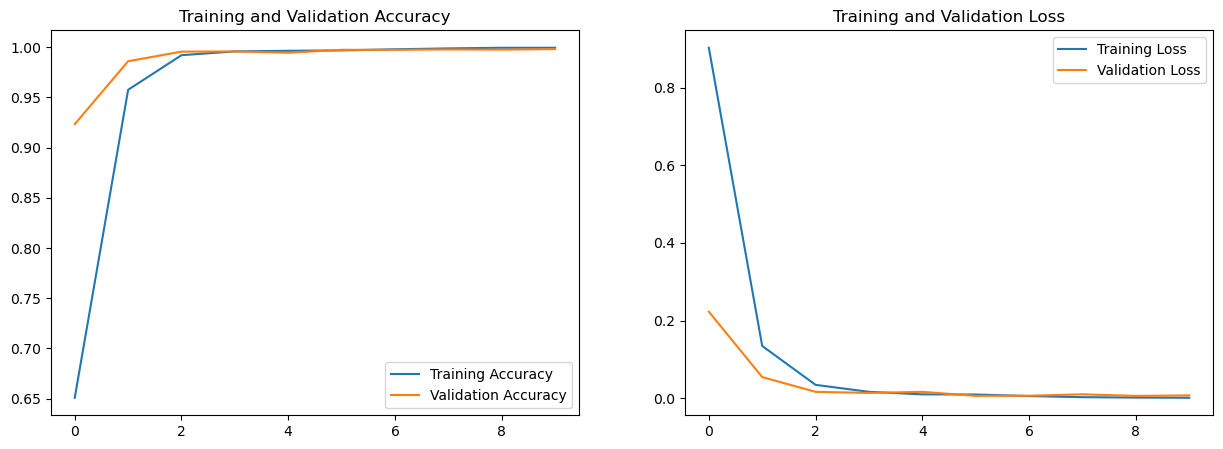

In [5]:
# 显示训练集和验证集的acc和loss曲线
# 训练集acc
acc = history.history['accuracy']
#测试集acc
val_acc = history.history['val_accuracy']
# 训练集loss
loss = history.history['loss']
# 测试集Loss
val_loss = history.history['val_loss']

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

本次共进行了10轮训练。从该曲线可以看出，在前两轮训练过程中，网络的准确率快速提高并达到一个较高水平，损失值快速下降。
后面八轮，网络在训练集与验证集的准确率都在 99% 以上，且波动不大。
在最后一轮训练时，在训练集与验证集上的准确率略微下降，损失值略微上升，但总体波动不大，此时考虑网络可能由于在达到较好准确率后再次进行多轮训练，使得网络出现过拟合现象。